In [2]:
import logging
import collections
import os
import pathlib
import re
import string
import sys
import tempfile
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyarrow.parquet as pa

import tensorflow as tf
import tensorflow.keras as k
import einops
import tensorflow_text
# import tensorflow_datasets as tfds
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [3]:
tf.get_logger().setLevel('ERROR')

In [4]:
table = pa.read_table('./data/to_spanish.parquet')
df = table.to_pandas()
df.head()
df = df.iloc[:350000,:]
len(df)

350000

In [5]:
table_val = pa.read_table('./data/to_spanish_val.parquet')
df_val = table_val.to_pandas()
df_val.head()

,translation
0,{'en': 'I don't even remember what the fight w...
1,{'en': 'Here are the sites of each of those th...
2,"{'en': 'I'm the man who killed Blackbeard.', '..."
3,"{'en': 'Don't get smart.', 'es': 'No te hagas ..."
4,{'en': 'Is there an exact moment in the life o...


In [6]:
en_train_ds = np.array([row['en'] for row in df['translation']])
sp_train_ds = np.array([row['es'] for row in df['translation']])

In [7]:
en_val_ds = np.array([row['en'] for row in df_val['translation']])
sp_val_ds = np.array([row['es'] for row in df_val['translation']])

In [8]:
# def load_data():
#   pwd = pathlib.Path.cwd()
#   english_train = pathlib.Path(os.path.join(pwd, 'data/en_sp/english.train.txt'))
#   spanish_train = pathlib.Path(os.path.join(pwd, 'data/en_sp/spanish.train.txt'))
#   english_val = pathlib.Path(os.path.join(pwd, 'data/en_sp/english.val.txt'))
#   spanish_val = pathlib.Path(os.path.join(pwd, 'data/en_sp/spanish.val.txt'))
  
#   en_train_text = english_train.read_text(encoding='utf-8')
#   sp_train_text = spanish_train.read_text(encoding='utf-8')
#   en_val_text = english_val.read_text(encoding='utf-8')
#   sp_val_text = spanish_val.read_text(encoding='utf-8')

#   sp_train_lines = sp_train_text.splitlines()
#   en_train_lines = en_train_text.splitlines()
#   sp_val_lines = sp_val_text.splitlines()
#   en_val_lines = en_val_text.splitlines()
  
  
#   sp_train_ds = np.array([line for line in sp_train_lines])
#   en_train_ds = np.array([line for line in en_train_lines])
#   sp_val_ds = np.array([line for line in sp_val_lines])
#   en_val_ds = np.array([line for line in en_val_lines])
  

#   return sp_train_ds, en_train_ds, sp_val_ds, en_val_ds

In [9]:
# sp_train_ds, en_train_ds, sp_val_ds, en_val_ds = load_data()


In [10]:
BUFFER_SIZE = 8000
BATCH_SIZE = 64

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((sp_train_ds, en_train_ds))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((sp_val_ds, en_val_ds))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [11]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Los miembros del Consejo tomaron nota de la decisi\xc3\xb3n que figuraba en su carta.'
 b'Pasa.' b'- S\xc3\xad. \xc2\xa1Mira esto!' b'- \xc2\xa1Lo tengo!'
 b'Porque pensamos que pedir tanto ...'], shape=(5,), dtype=string)

tf.Tensor(
[b'They take note of the decision contained in your letter.'
 b'Come on in.' b'Yeah, look at this.' b'- I got it!'
 b"Because we thought we'd both ask him."], shape=(5,), dtype=string)


In [12]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tensorflow_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [13]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tensorflow_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [14]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [15]:
max_vocab_size = 8000

spanish_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [16]:
max_vocab_size = 8000

english_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [17]:
spanish_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
spanish_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'de', ',', 'la', 'que', 'el']

In [18]:
english_text_processor.adapt(train_raw.map(lambda context, target: target))

# Here are the first 10 words from the vocabulary:
english_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', ',', 'of', 'to', 'and']

In [19]:
example_tokens = spanish_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 13, 132, 18, 98, 5673, 617, 5, 7, 262, 8, 1, 10, 28, 591, 4, 3],
 [2, 338, 4, 3], [2, 29, 4, 267, 53, 27, 3]]>

In [20]:
context_vocab = np.array(spanish_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] los miembros del consejo tomaron nota de la decision que [UNK] en su carta . [END]'

Text(0.5, 1.0, 'Mask')

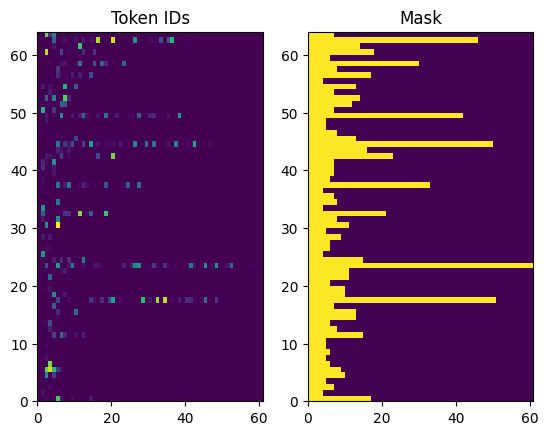

In [21]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [22]:
def process_text(context, target):
  context = spanish_text_processor(context).to_tensor()
  target = english_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [23]:

for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy())

[  2  16  92 144  15   3   0   0   0   0]

[ 2 72 24 12 14  0  0  0  0  0]
[72 24 12 14  3  0  0  0  0  0]


In [24]:
UNITS = 256

In [25]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    # shape_checker = ShapeChecker()
    # shape_checker.shapecheck(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    # shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    # shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [26]:
# Encode the input sequence.
encoder = Encoder(spanish_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 154)
Encoder output, shape (batch, s, units): (64, 154, 256)


In [27]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    # shape_checker = ShapeChecker()

    # shape_checker(x, 'batch t units')
    # shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    # shape_checker(x, 'batch t units')
    # shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    # shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [28]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(english_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 154, 256)
Target sequence, shape (batch, t, units): (64, 115, 256)
Attention result, shape (batch, t, units): (64, 115, 256)
Attention weights, shape (batch, t, s):    (64, 115, 154)


In [29]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 0.99999994, 1.        , 1.        ,
       0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 ,
       0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 ,
       0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 ,
       0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 ,
       0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 ,
       0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 ,
       0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 ,
       0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 ,
       0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 ,
       0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 ,
       0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 ,
       0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 ,
       0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 ,
       0.9999999 , 0.9999999 , 0.9999999 , 0.9999999 , 0.99999

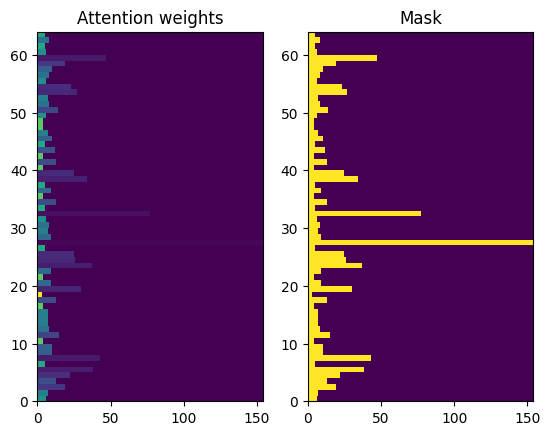

In [30]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [31]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [32]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  # shape_checker = ShapeChecker()
  # shape_checker(x, 'batch t')
  # shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  # shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  # shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  # shape_checker(x, 'batch t units')
  # shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  # shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [33]:
decoder = Decoder(english_text_processor, UNITS)

In [34]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 154, 256)
input target tokens shape: (batch, t) (64, 115)
logits shape shape: (batch, target_vocabulary_size) (64, 115, 8000)


In [35]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [36]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [37]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [38]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'hm smells shut tender meanwhile tie agendas tries unto houses',
       b'holidays congratulations politicians april mirror impact financed introducing analyse box',
       b'category plate kissed welcome shouting television charles reserved underwear on'],
      dtype=object)

In [39]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [62]:
model = Translator(UNITS, spanish_text_processor, english_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 154)
Target tokens, shape: (batch, t) (64, 115)
logits, shape: (batch, t, target_vocabulary_size) (64, 115, 8000)


In [63]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [64]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [65]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [66]:
vocab_size = 1.0 * english_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.987197, 'expected_acc': 0.000125}

In [67]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 5s 34ms/step - loss: 8.9914 - masked_acc: 9.8411e-05 - masked_loss: 8.9914


{'loss': 8.991401672363281,
 'masked_acc': 9.841083374340087e-05,
 'masked_loss': 8.991401672363281}

In [68]:
history = model.fit(
    train_ds.repeat(), 
    epochs=200,
    steps_per_epoch = 300,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=15)])

Epoch 1/200
300/300 [==============================] - 28s 69ms/step - loss: 5.1861 - masked_acc: 0.2256 - masked_loss: 5.1861 - val_loss: 4.6830 - val_masked_acc: 0.2738 - val_masked_loss: 4.6830
Epoch 2/200
300/300 [==============================] - 21s 69ms/step - loss: 4.3254 - masked_acc: 0.3209 - masked_loss: 4.3254 - val_loss: 4.2153 - val_masked_acc: 0.3354 - val_masked_loss: 4.2153
Epoch 3/200
300/300 [==============================] - 20s 67ms/step - loss: 3.8708 - masked_acc: 0.3773 - masked_loss: 3.8708 - val_loss: 3.8309 - val_masked_acc: 0.3784 - val_masked_loss: 3.8309
Epoch 4/200
300/300 [==============================] - 20s 68ms/step - loss: 3.5715 - masked_acc: 0.4158 - masked_loss: 3.5715 - val_loss: 3.5574 - val_masked_acc: 0.4078 - val_masked_loss: 3.5574
Epoch 5/200
300/300 [==============================] - 20s 68ms/step - loss: 3.3566 - masked_acc: 0.4414 - masked_loss: 3.3566 - val_loss: 3.3910 - val_masked_acc: 0.4292 - val_masked_loss: 3.3910
Epoch 6/200
300

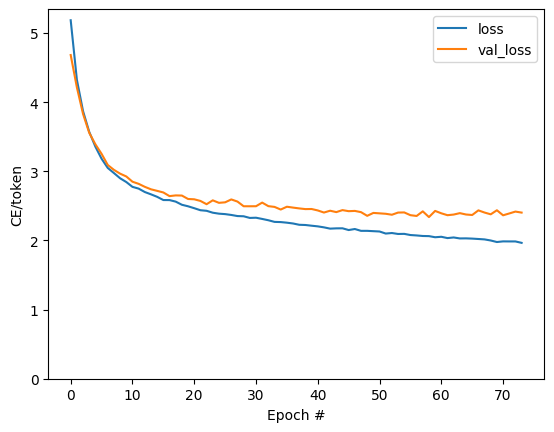

In [69]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

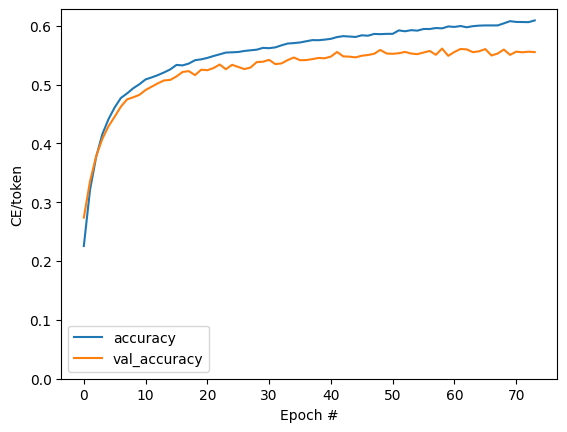

In [70]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [71]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [72]:
result = model.translate(['¿Todavía está en casa?']) # Are you still home
result[0].numpy().decode()

'is it still at home ? '

In [73]:
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_664\2375050876.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_664\2375050876.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


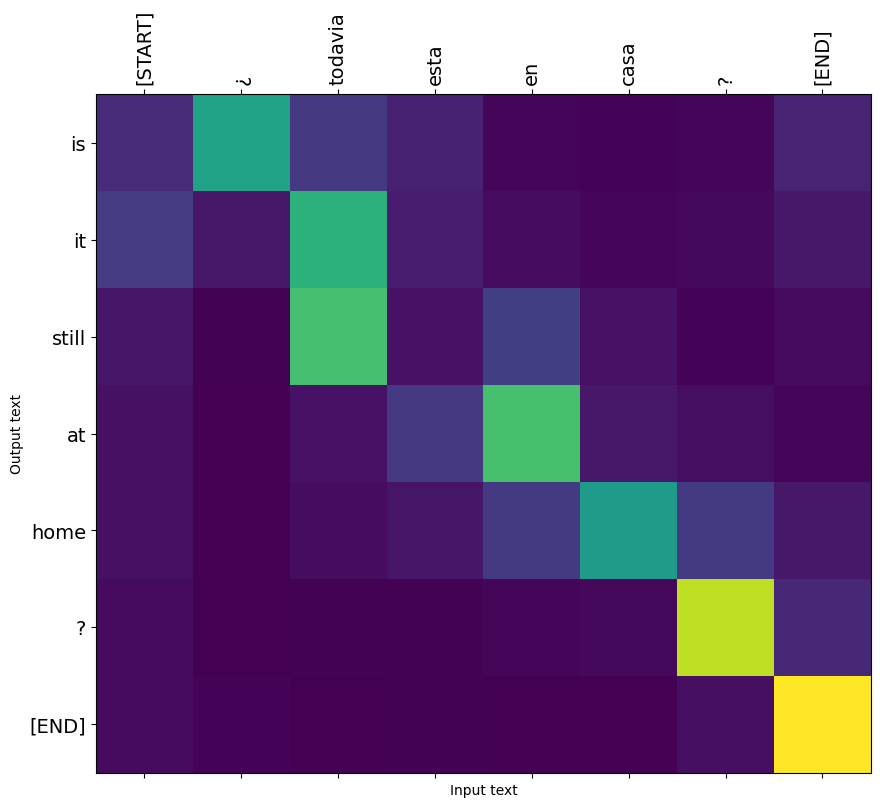

In [74]:
model.plot_attention('¿Todavía está en casa?') # Are you still home

C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_664\2375050876.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_664\2375050876.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


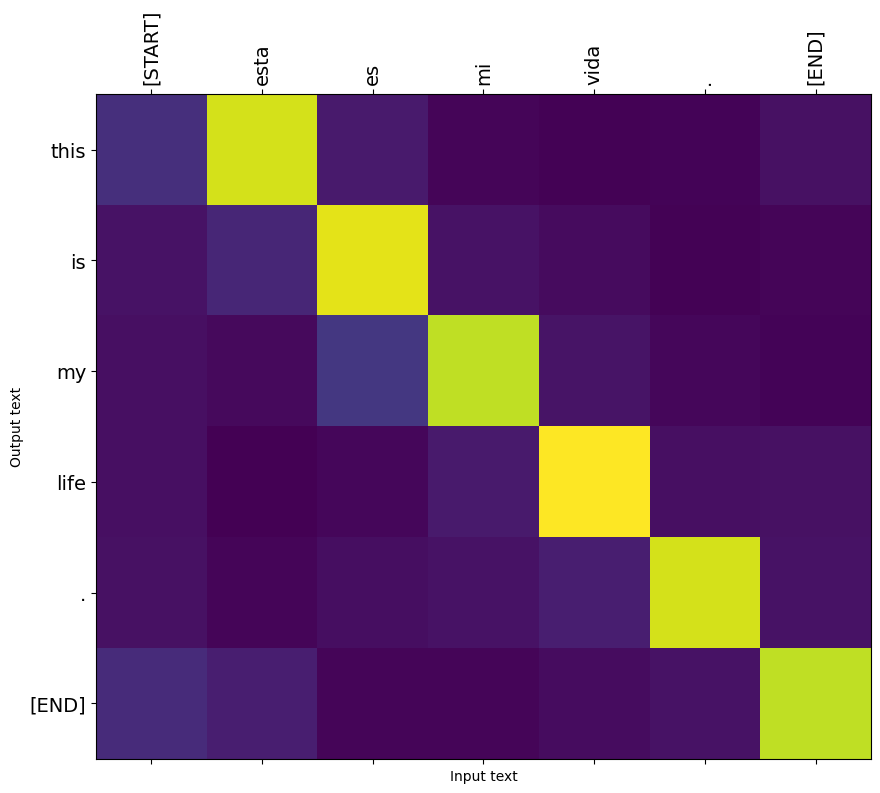

In [75]:
model.plot_attention('Esta es mi vida.')

C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_664\2375050876.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_664\2375050876.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


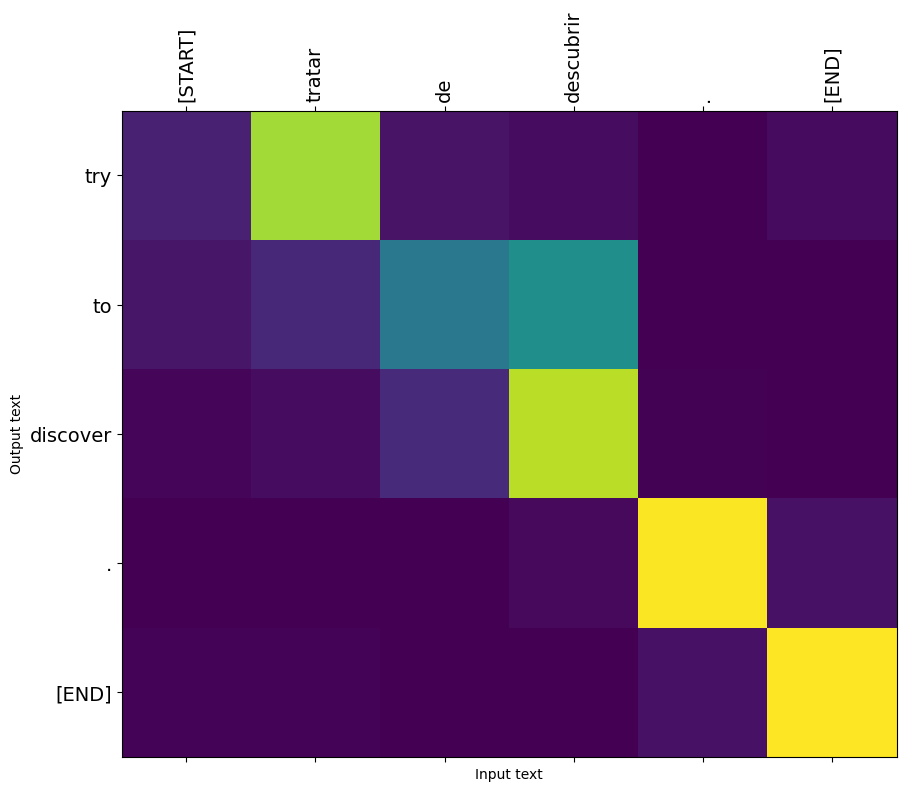

In [76]:
model.plot_attention('Tratar de descubrir.')

In [77]:
long_text = """Tras reunirse este jueves, los gobiernos de Venezuela y Guyana acordaron seguir con el diálogo respecto a la disputa por el territorio Esequibo. Esto fue lo más destacado."""

C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_664\2375050876.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_664\2375050876.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


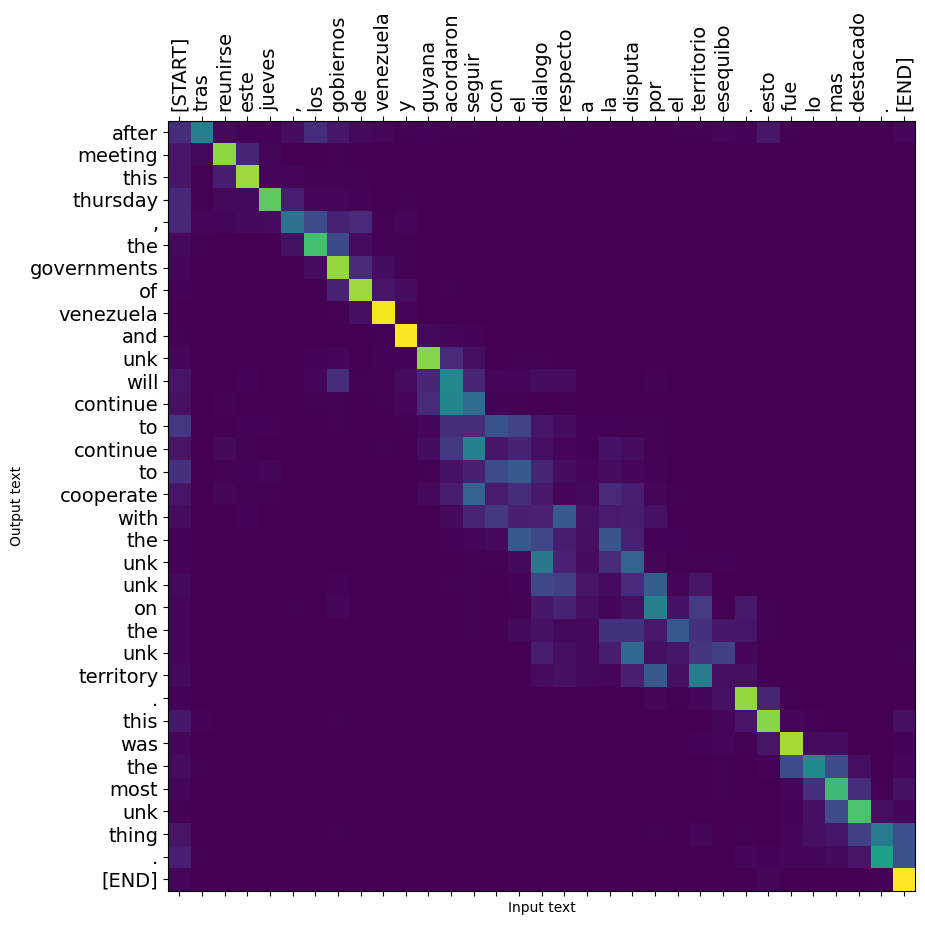

In [78]:
model.plot_attention("".join(long_text))

In [79]:
inputs = [
    'Hace mucho frio aqui.', # "It's really cold here."
    'Esta es mi vida.', # "This is my life."
    'Su cuarto es un desastre.' # "His room is a mess"
]

In [80]:
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

its a lot of cold here . 
this is my life . 
his room is a disaster . 



In [81]:
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its a lot of cold here . 
this is my life .   
his room is a disaster .  



In [82]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [83]:
export = Export(model)

In [84]:
_ = export.translate(tf.constant(inputs))

In [85]:
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its a lot of cold here .                                           
this is my life .                                             
his room is a disaster .                                            



In [86]:
tf.saved_model.save(export, 'models/es_en_translation',
                    signatures={'serving_default': export.translate})

In [87]:
reloaded = tf.saved_model.load('models/es_en_translation')
_ = reloaded.translate(tf.constant(inputs)) #warmup

In [88]:
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

its a lot of cold here .                                           
this is my life .                                             
his room is a disaster .                                            



In [89]:
converter = tf.lite.TFLiteConverter.from_keras_model(export)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()
# Save the model.
with open('tflite_models/es_en_translation.tflite', 'wb') as f:
  f.write(tflite_model)

In [90]:
interpreter = tf.lite.Interpreter(model_path='tflite_models/es_en_translation.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']

interpreter.set_tensor(input_details[0]['index'], np.array([inputs[0]]))

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)


[b'its a lot of cold here .                                           ']
